In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
##### Fonction de dénormalisation de certaines variables
def un_normalize_max_min(x, max_val, min_val):
    return (max_val - min_val)*x + min_val

## Partie 1 : Chargement des données de location de vélos

In [3]:
# Données
url_data = "C:/Users/PC Maison/7-OPENCLASSROOM/OC-COURS-24-APPRENTISSAGE-STATISTIQUE_OBJETS_CONNECTES/bikes.csv"
df = pd.read_csv(url_data, delimiter=',') 

# On enlève certaines colonnes que nous n'utiliserons pas dans la suite
drop_var = ['date', 'season', 'year', 'month', 'weekday']
df = pd.DataFrame(df.drop(drop_var, axis=1))

# sommaire
n, p = df.shape
print("Données contiennent = {} points et {} variables".format(n, p))
print('Désignation des variables :',  df.columns)


Données contiennent = 731 points et 9 variables
Désignation des variables : Index(['holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity',
       'windspeed', 'registered', 'count'],
      dtype='object')


### Remarque
La variable à prédire (la sortie $y$) est la variables "count". Les entrées $x$ sont les variables restantes

### Quelques traitements appliqués aux données

In [4]:
# one-hot encoding des variables discrètes ayant plus de deux modalités
df = pd.get_dummies(df, columns=['weather'])
n, p = df.shape
print("Données après le one hot encoding contiennent = {} points et {} variables \n".format(n, p))

# Dénormalisation des variables temperature, atemp et humidity 
# temp
df['temp'] = un_normalize_max_min(df['temp'], max_val=39, min_val=-8)
#atemp
df['atemp'] = un_normalize_max_min(df['atemp'], max_val=50, min_val=-10)
#humidity
df['humidity'] = un_normalize_max_min(df['humidity'], max_val=100, min_val=0)

# Résumé des données
print('Résumé des données')
df.describe()

Données après le one hot encoding contiennent = 731 points et 11 variables 

Résumé des données


,holiday,workingday,temp,atemp,humidity,windspeed,registered,count,weather_1,weather_2,weather_3
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.028728,0.683995,15.283085,18.461239,62.789406,0.190486,3656.172367,4504.348837,0.633379,0.337893,0.028728
std,0.167155,0.465233,8.603397,9.777671,14.242910,0.077498,1560.256377,1937.211452,0.482212,0.473316,0.167155
min,0.000000,0.000000,-5.220871,-5.255824,0.000000,0.022392,20.000000,22.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,7.842925,10.270550,52.000000,0.134950,2497.000000,3152.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,15.421651,19.203980,62.666700,0.180975,3662.000000,4548.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,22.804575,26.516120,73.020850,0.233214,4776.500000,5956.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,32.498349,40.453760,97.250000,0.507463,6946.000000,8714.000000,1.000000,1.000000,1.000000


## Partie 2 : Analyse statistique

<AxesSubplot:>

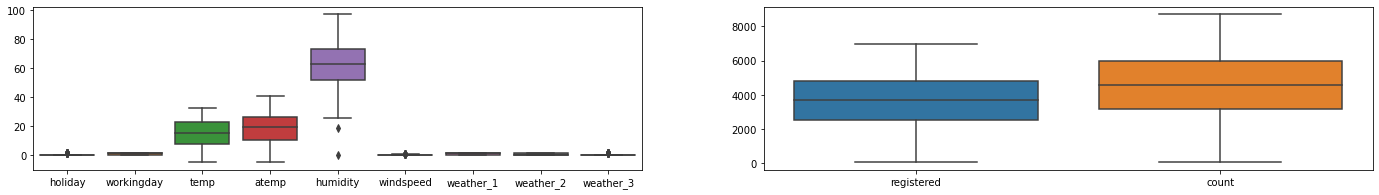

In [5]:
# Boite à moustaches des entrées 
plt.figure(figsize=(24, 3))
plt.subplot(121)
index = ['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'weather_1', 'weather_2', 'weather_3']
sns.boxplot(data=df[index], orient="v")
#'registered', 'count' (on trace ces deux variables ensembles pour des raisons de lisibilité)
plt.subplot(122)
sns.boxplot(data=df[['registered', 'count']], orient="v")

#### Commentez les graphiques obtenus

#### Réponse
On peut faire les remarques suivantes :
* les variables explicatives ont des moyennes et des variances différentes
* les variables ont des plages de variation différentes

Une normalisation des variables (pour les rendre à la même échelle) sera nécessaire avant l'apprentissage du modèle de régression linéaire

### Analyse de corrélation linéaire

<AxesSubplot:>

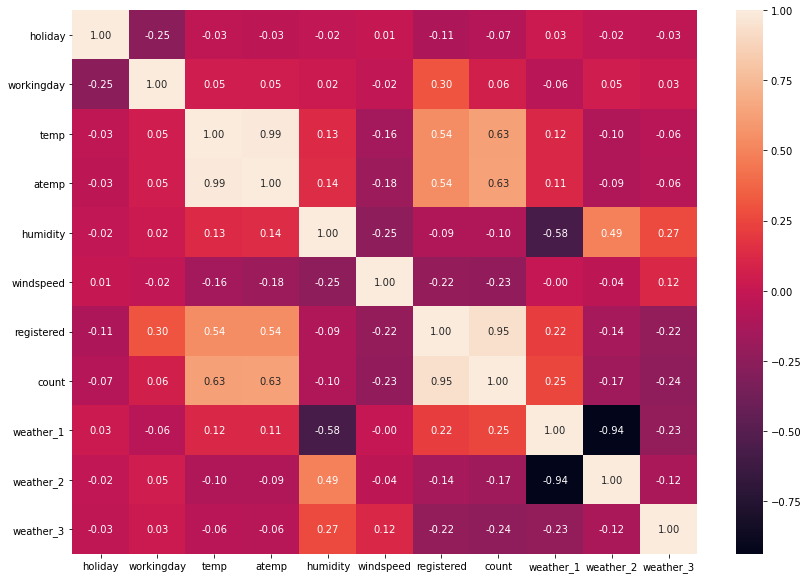

In [6]:
# Correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f")

#### Commentez le graphique

#### Réponse
Globalement les variables sont peu correlées linéairement à l'exception de "temp" et "atemp" qui sont fortement liées. On peut pour la modélisation ne garder qu'une des deux variables.

## Partie 3 :  Mise en forme des données
On va récupérer les données sous la forme de la matrice des entrées X et le vecteur de sortie Y comme vu dans le cours 

In [7]:
variables = ['holiday', 'workingday', 'temp', 'humidity', 'windspeed','registered', 'weather_1', 'weather_2', 'weather_3']
X = df[variables].values
Y = df['count'].values

### Découpage des données en données d'apprentissage, validation et test

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3, random_state=42, stratify=X[:,8])
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=1/2, random_state=42, stratify=X_train[:,8])
print("L'ensemble d'apprentissage comprend {} points".format(X_train.shape[0]))
print("L'ensemble de validation a {} points et le test {} points".format(X_val.shape[0], X_test.shape[0]))

L'ensemble d'apprentissage comprend 243 points
L'ensemble de validation a 244 points et le test 244 points


#### Question 
Quel est l'intérêt de faire ce découpage ?

#### Réponse
Pour éviter le sur-apprentissage. 
* Le réglage des hyper-paramètres du modèle de prédiction (ou encore la sélection du modèle de régression) se fait sur la base des données de validation.
* Les données de test servent à estimer les capacités de généralisation du modèle

### Normalisation des variables

In [9]:
# X
scaler_X = preprocessing.StandardScaler()
scaler_X.fit(X_train)
X_train_n = scaler_X.transform(X_train)
X_val_n = scaler_X.transform(X_val)
X_test_n = scaler_X.transform(X_test)

#### Question 
Pourquoi faut-il normaliser les données avant de faire la régression linéaire ?

#### Réponse
Parce que les variables explicatives ont des plages de variation différentes. 



## Partie 4 : Réalisez le modèle de régression linéaire 

L'objectif dans un premier temps est de construire le modèle $f(x) = \beta_0 + x^\top \beta$ avec $x \in \mathbb{R}^d$ le vecteur des entrées, $\beta$ le vecteur des paramètres et $\beta_0$ le biais. 

Construire ce modèle et évaluez ces performances

Indication : on peut se servir de la fonction sklearn.linear_model.LinearRegression

In [10]:
from sklearn.linear_model import LinearRegression

# apprentissage du modèle linéaire
model = LinearRegression()
model.fit(X_train_n, Y_train) 

LinearRegression()

In [11]:
# prédictions
# sur les données d'apprentissage
Y_pred_train = model.predict(X_train_n) 

# sur les données de test
Y_pred_test = model.predict(X_test_n) 

In [12]:
def trace_resultats(Y_vrai, Y_pred, titre):
    plt.figure(figsize=(18,4))
    # prédictions
    plt.subplot(121), plt.scatter(Y_vrai, Y_pred), plt.plot([0, 8000], [0, 8000], '--r')
    plt.xlabel("Vraies observations",fontsize = 18)
    plt.ylabel("Predictions",fontsize = 18)
    plt.title(titre,fontsize = 18)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    # erreurs
    erreurs = Y_vrai - Y_pred
    plt.subplot(122), plt.hist(erreurs)
    plt.xlabel("Erreurs",fontsize = 18)
    plt.ylabel("Effectifs",fontsize = 18)
    plt.title(titre,fontsize = 18)

from sklearn.metrics import r2_score, mean_squared_error
def calcul_performance(Y_vrai, Y_pred):
    r2 = r2_score(Y_vrai, Y_pred)
    mse = mean_squared_error(Y_vrai, Y_pred)
    return r2, mse
    

--------------------------------------------------
Régression linéaire : performances
--------------------------------------------------
Coefficient de détermination R2 (apprentissage) = 0.9633
MSE (apprentissage) = 144088.1175
Coefficient de détermination R2 (test) = 0.9675
MSE test = 119589.7108
--------------------------------------------------


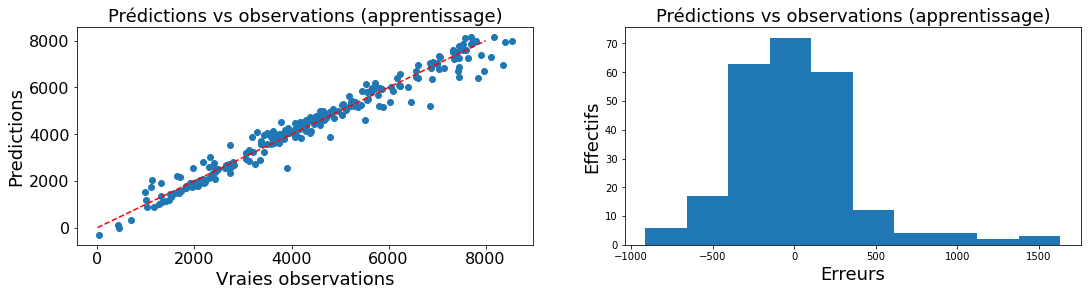

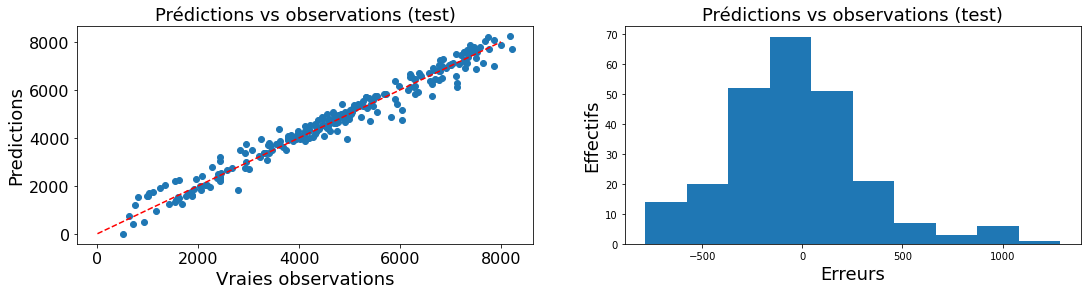

In [13]:
# tracés
trace_resultats(Y_train, Y_pred_train, "Prédictions vs observations (apprentissage)")
trace_resultats(Y_test,  Y_pred_test,  "Prédictions vs observations (test)")

# mesures des performances
R2_train, mse_train = calcul_performance(Y_train, Y_pred_train)
R2_test, mse_test   = calcul_performance(Y_test,  Y_pred_test)

# affichage des performances
dash = '-' * 50
print(dash)
print("Régression linéaire : performances")
print(dash)
print("Coefficient de détermination R2 (apprentissage) = {:.4f}".format(R2_train))
print("MSE (apprentissage) = {:.4f}".format(mse_train))
print("Coefficient de détermination R2 (test) = {:.4f}".format(R2_test))
print("MSE test = {:.4f}".format(mse_test))
print(dash)

## Partie 5 : sélection de variables

Pour cela nous réalisons une régression pénalisée
$
\min_{\beta_0, \, \beta} \sum_{i=1}^n \left(y_i - \beta_0 - x_i^\top \beta \right)^2 + \lambda \Omega(\beta)
$
avec : 
* Pour la régression Ridge 
$\Omega(\beta) = \sum_{j=1}^p \beta_j^2$
* Pour le lasso 
$\Omega(\beta) = \sum_{j=1}^p |\beta_j|$

### Mise en oeuvre
* Testez les régressions ridge et lasso
* Que se passe-t-il quand on fait varier le paramètre de régularisation $\lambda$. On pourra tracer, comme dans le cours sur la régression linéaire, le chemin de régularisation. 
* Montrez comment choisir convenablement la bonne valeur de $\lambda$
* Comparez et commentez les résultats obtenus pour la régression ridge et lasso.

On peut utiliser les fonctions suivantes de Scikit-Learn
* Ridge : sklearn.linear_model.Ridge
* Lasso : sklearn.linear_model.Lasso

In [14]:
# fonction qui calcule la solution de la régression ridge et lasso pour différentes valeurs de $\lambda$
# les parametres $\beta$ sont stockes dans une matrice. 
# pour chaque solution on evalue les performances sur les données de validation
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
def calcul_chemin_regul(X, Y, vect_lam, meth='lasso', Xval=None, Yval=None):
    nlam = vect_lam.shape[0]
    nparam = X.shape[1]
    M_param = np.empty((nlam, nparam))
    gen_error = np.zeros(nlam)
    for i, lam in enumerate(vect_lam):
        if meth=='lasso':
            model = Lasso(alpha=lam).fit(X, Y)
            M_param[i,:] = model.coef_
        elif meth=='ridge':
            model = Ridge(alpha=lam).fit(X, Y)
            M_param[i,:] = model.coef_
        if Xval is not None:
            Y_pred_val = model.predict(Xval)
            gen_error[i] = mean_squared_error(Yval, Y_pred_val) 
            
    return M_param, gen_error

In [15]:
# trace du chemin de regularisation et de l'erreur sur les données validation
def trace_chemin_regul(vect_lam, chemin, variables, titre=''):
    plt.figure(figsize=(18,5.5))
    for k in range(chemin.shape[1]):
        # normalisation des paramètres entre -1 et 1 pour une meilleure visualisation
        tmp_var = chemin[:,k]/(np.abs(chemin[:,k]).max())
        plt.semilogx(vect_lam, tmp_var, marker = 's', markersize=6, linewidth=2.5)
        
    plt.legend(variables, loc='lower right')
    plt.title(titre, fontsize=16)
    plt.xlabel(r'Paramètre de régularisation $\lambda$', fontsize=16)
    plt.ylabel(r'Paramètres $\beta$ normalisés', fontsize=16)
    plt.xticks(fontsize=14), plt.yticks(fontsize=14)

def trace_perf(vect_lam, perf, titre=''):
    plt.figure(figsize=(16,5.5))
    plt.semilogx(vect_lam, perf, marker = 's', markersize=6, linewidth=2.5)
    
    plt.title(titre, fontsize=16)
    plt.xlabel(r'Paramètre de régularisation $\lambda$', fontsize=16)
    plt.ylabel('Erreur de validation', fontsize=16)
    plt.xticks(fontsize=14), plt.yticks(fontsize=14)

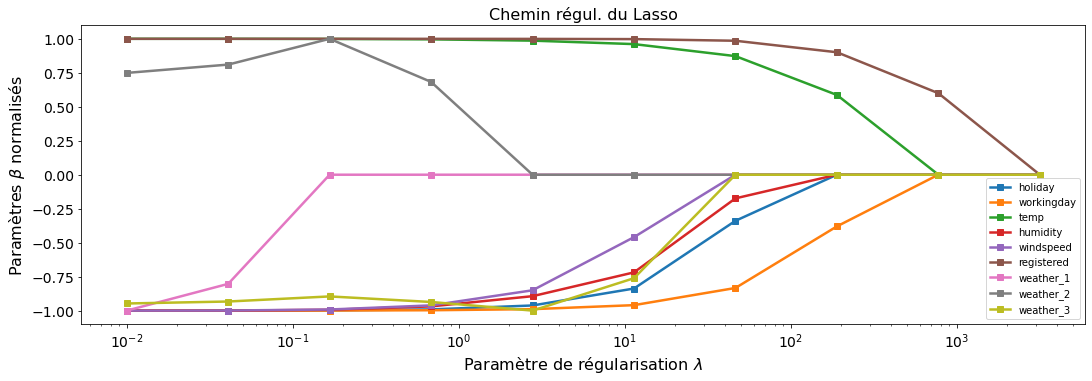

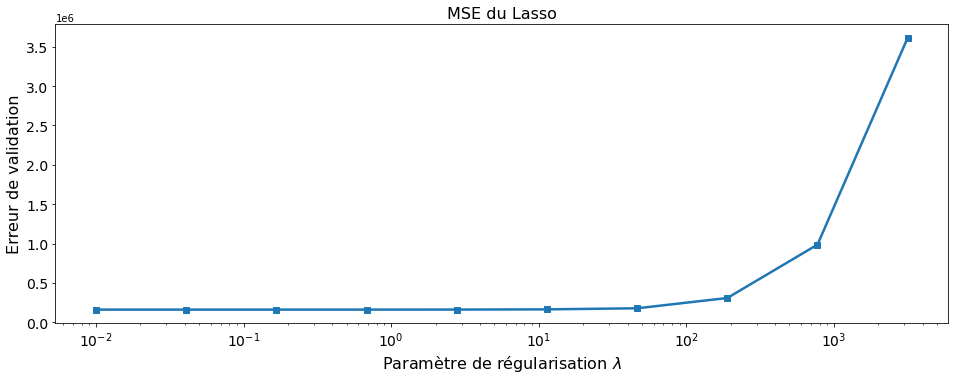

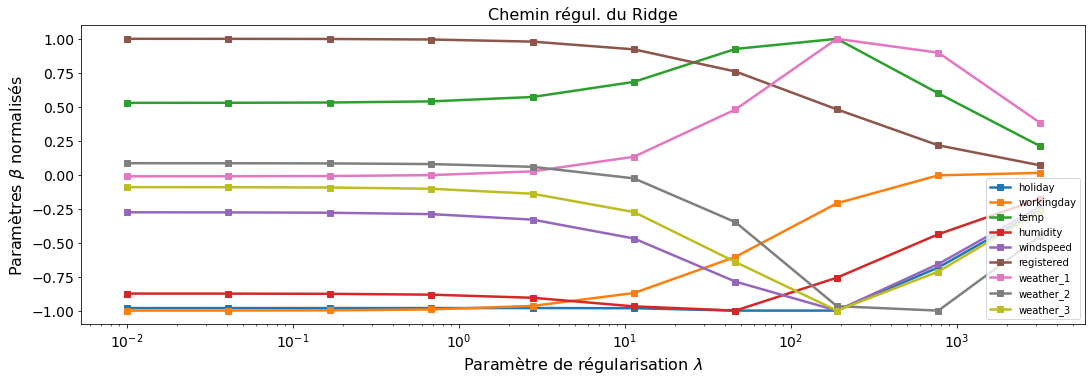

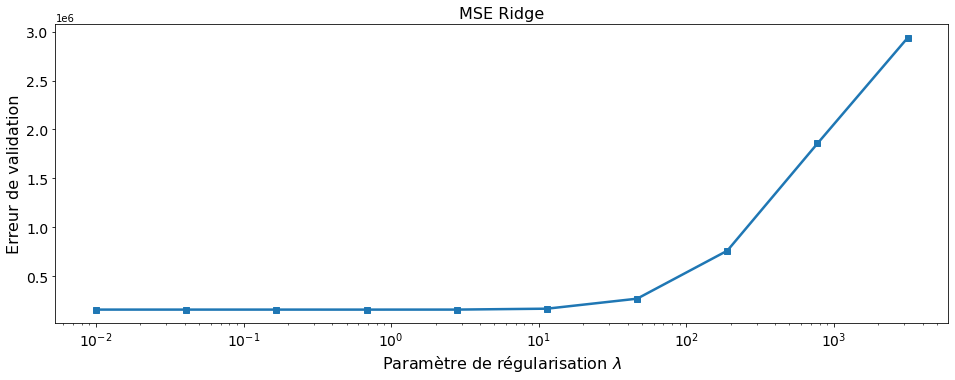

In [16]:
# choix des valeurs de lambda (à tester) sur une échelle logarithmique
vect_lam = np.logspace(-2, 3.5, 10)

# Calcul et tracé du chemin de régularisation de la régression Lasso
chemin_lasso, perf_lasso = calcul_chemin_regul(X_train_n, Y_train, vect_lam, 'lasso', X_val_n, Y_val)
trace_chemin_regul(vect_lam, chemin_lasso, variables, titre='Chemin régul. du Lasso')
trace_perf(vect_lam, perf_lasso, titre='MSE du Lasso')

# Calcul et tracé du chemin de régularisation de la régressionRidge
chemin_ridge, perf_ridge = calcul_chemin_regul(X_train_n, Y_train, vect_lam, 'ridge', X_val_n, Y_val)
trace_chemin_regul(vect_lam, chemin_ridge, variables, titre='Chemin régul. du Ridge')
trace_perf(vect_lam, perf_ridge, titre='MSE Ridge')

### Remarques
On constate que :
* en augmentant le paramètre de régularisation $\lambda$ la régularisation Lasso pousse plus de paramètres $\beta$ vers 0 contrairement à la régularisation Ridge,
* pour le Lasso ou la Ridge il y a une plage de valeurs de $\lambda$ ($[10^{-2}, 50])$ pour laquelle le MSE (mean squared error, erreur quadratique moyenne) varie peu sur les données de validation
Nous allons choisir pour le modèle final (Lasso ou Ridge) une valeur de $\lambda$ entre 10 et 50. 

In [17]:
## Modèle final pour la régression Ridge et Lasso
lam_final = 20

# Lasso
model_lasso = Lasso(alpha=lam_final).fit(X_train_n, Y_train)
R2_test_L, mse_test_L   = calcul_performance(Y_test,  model_lasso.predict(X_test_n))
# affichage des performances
dash = '-' * 50
print(dash)
print("Régression linéaire Lasso : performances")
print(dash)
print("Coefficient de détermination R2 (test) = {:.4f}".format(R2_test_L))
print("MSE test = {:.4f}".format(mse_test_L))
print(dash)

#Ridge
model_ridge = Ridge(alpha=lam_final).fit(X_train_n, Y_train)
R2_test_R, mse_test_R   = calcul_performance(Y_test,  model_ridge.predict(X_test_n))
# affichage des performances
dash = '-' * 50
print(dash)
print("Régression linéaire Ridge : performances")
print(dash)
print("Coefficient de détermination R2 (test) = {:.4f}".format(R2_test_R))
print("MSE test = {:.4f}".format(mse_test_R))
print(dash)

--------------------------------------------------
Régression linéaire Lasso : performances
--------------------------------------------------
Coefficient de détermination R2 (test) = 0.9674
MSE test = 120097.0575
--------------------------------------------------
--------------------------------------------------
Régression linéaire Ridge : performances
--------------------------------------------------
Coefficient de détermination R2 (test) = 0.9608
MSE test = 144501.1320
--------------------------------------------------


#### Comparaison des paramètres des 3 modèles : régression, Lasso, Ridge ####




In [18]:
# Printing all the results
dash = '-' * 60
print(dash)
print("{:<18s}{:<10s}{:<12s}{:<10s}".format('Variable',  'Linéaire', 'RIDGE', 'Lasso'))
print(dash)
for k in range(len(variables)+1):
    if k==0:
        print("{:<10s}{:>12.3f}{:>12.3f}{:>12.3f}".format("Intercept", model.intercept_, model_ridge.intercept_, model_lasso.intercept_))
    else:
        print("{:<10s}{:>12.3f}{:>12.3f}{:>12.3f}".format(variables[k-1], model.coef_[k-1], model_ridge.coef_[k-1], model_lasso.coef_[k-1]))
print(dash)

------------------------------------------------------------
Variable          Linéaire  RIDGE       Lasso     
------------------------------------------------------------
Intercept     4411.885    4411.885    4411.885
holiday        -94.159     -94.590     -67.045
workingday    -446.247    -352.358    -415.111
temp           212.833     309.399     199.027
humidity       -68.514     -78.308     -37.129
windspeed      -28.488     -59.504      -1.853
registered    1856.396    1621.377    1849.336
weather_1       -0.983      19.014       0.000
weather_2        4.240      -5.629      -0.000
weather_3       -8.964     -38.308      -5.063
------------------------------------------------------------


### Remarque
La régression Lasso obtient les mêmes performances que la régression Ridge et la régression classique mais avec moins de variables explicatives